In [26]:
# Base packages
from torch.utils.data import Dataset
import torch
from torch.utils.data import DataLoader

# Defined packages
from inputs import RandomPattern, noise_input
from neuralBehaviors import *
from synapseBehaviors import *
from metrics import draw_weights

# PyMonnTorch and CoNeX
from pymonntorch import NeuronGroup, SynapseGroup, NeuronDimension, EventRecorder, Recorder

from conex import Neocortex, InputLayer, Synapsis, prioritize_behaviors, CorticalColumn
from conex.behaviors.synapses import SynapseInit, WeightInitializer, LateralDendriticInput, SimpleDendriticInput, WeightNormalization
from conex.behaviors.synapses.learning import SimpleSTDP
from conex.behaviors.neurons.axon import NeuronAxon
from conex.behaviors.neurons.specs import SpikeTrace, Fire, KWTA
from conex.behaviors.neurons.dendrite import SimpleDendriteStructure, SimpleDendriteComputation
from conex.behaviors.neurons.neuron_types.lif_neurons import LIF, ELIF
from conex.behaviors.neurons import ActivityBaseHomeostasis, VoltageBaseHomeostasis
from conex.behaviors.network.time_resolution import TimeResolution

PATTERNS_COUNTS = 5
OUT_COUNTS = 3
LEN = 3
ITERS = 1000

SIZE = PATTERNS_COUNTS * LEN
TIME = 30
NORM = 15
USE_LI = True
USE_KWTA = True
USE_VH = False # voltage based homeostasis
USE_AH = True # activity based homeostasis

patterns = []
pats = [
    [1, 1, 0],#6
    [1, 1, 1],#7
    [0, 0, 1],#1
    [0, 1, 1],#3
    [1, 0, 0],#4
    [0, 1, 0],#2
    [1, 0, 1],#5

]

for i in range(PATTERNS_COUNTS):
    p =torch.zeros(PATTERNS_COUNTS * LEN)
    p[i * LEN: (i+1) * LEN] = torch.tensor(pats[i])
    patterns.append(p)


dataset = RandomPattern(
    patterns=patterns,
    period=20,
)


net = Neocortex(dt=0.1)

input_layer = NeuronGroup(size=SIZE, net=net, behavior={
    160: ResetIBehavior(),
    170: InputBehavior(dataset, isForceSpike=True),
    # 175: InputBehavior(noise_input, mean=0, std=0.01),
    # 260: LIFBehavior(func='base', R=10),
    # 340: FireBehavior(),
    360: SpikeTrace(tau_s=0.5),
    380: NeuronAxon(),
    500: EventRecorder(variables=['spikes']),
    
})


conex_out_behaviors = [
        SimpleDendriteStructure(), # 220
        SimpleDendriteComputation(), # 240
        SpikeTrace(tau_s=0.5), # 360
        NeuronAxon(), # 380
        
    ]
if USE_AH:
    conex_out_behaviors.append(ActivityBaseHomeostasis(activity_rate=1, window_size=3, updating_rate=1.0))
if USE_VH:
    conex_out_behaviors.append(VoltageBaseHomeostasis(max_ta=-30, min_ta=-75))
all_out_behs = {**prioritize_behaviors(conex_out_behaviors),
    260: LIFBehavior(func='base', R=100),
    340: FireBehavior(),
    341: Recorder(variables=['v']), # right after Fire
    500: EventRecorder(variables=['spikes']),
    }
if USE_LI:
    all_out_behs[350] = LateralInhibition(alpha=50)
if USE_KWTA:
    all_out_behs[300] = KWTABehavior(k=1)

out_ng = NeuronGroup(net=net, size=OUT_COUNTS, tag='out', behavior=all_out_behs)
synapsis_input_out = SynapseGroup(net=net, src=input_layer, dst=out_ng, behavior={
                                    **prioritize_behaviors(
                                      [
                                        SynapseInit(), # 2
                                        WeightInitializer(mode='random', weight_shape=(PATTERNS_COUNTS * LEN, OUT_COUNTS), scale=1 + NORM // SIZE), # 3
                                        SimpleDendriticInput(), # 180
                                        SimpleSTDP(a_plus=10, a_minus=10), # 400
                                        WeightNormalization(norm=NORM) # 420
                                      ]),
                                      500: Recorder(variables=['weights']),}
                                    , tag="Proximal")



net.initialize(info=False)
oldW = synapsis_input_out.weights.clone()
net.simulate_iterations(ITERS, measure_block_time=False)
newW = synapsis_input_out.weights.clone()

print(f"\nDiff W = \n{newW - oldW}")

print(f"input layer spikes: {input_layer['spikes'][0].shape[0]}")
print(f"out layer spikes: {out_ng['spikes'][0].shape[0] if out_ng['spikes'] else 0}")

print(f"Weights:\n{synapsis_input_out.weights}")




Diff W = 
tensor([[-0.0284, -0.3058,  0.8105],
        [ 0.0200, -0.4872,  0.8126],
        [ 0.1184,  0.1220,  0.2448],
        [-0.2340, -0.2795, -1.0562],
        [-0.2309, -0.0287, -1.0169],
        [-0.2966, -0.2901, -0.9496],
        [ 0.2916,  0.2619,  0.0383],
        [ 0.2389,  0.2289,  0.2176],
        [ 0.6777, -0.0644, -0.0225],
        [ 0.2110,  0.1607,  0.2585],
        [-0.6603, -0.0173,  0.1232],
        [-0.7085, -0.0981, -0.0127],
        [ 0.1985,  0.5432,  0.2852],
        [ 0.2196,  0.1552,  0.1127],
        [ 0.1831,  0.0990,  0.1544]])
input layer spikes: 1800
out layer spikes: 82
Weights:
tensor([[ 0.7510,  1.2773,  2.8432],
        [ 1.0999, -0.1734,  2.8575],
        [ 0.8541,  0.9757,  1.7056],
        [ 0.5056, -0.0324, -0.6853],
        [ 0.5279,  1.9727, -0.4111],
        [ 0.0540, -0.1174,  0.0577],
        [ 2.1033,  2.0943,  0.2671],
        [ 1.7228,  1.8304,  1.5162],
        [ 2.0925,  0.0961,  0.6993],
        [ 1.5214,  1.2852,  1.8017],
        

Patterns:
	0:tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
	1:tensor([0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
	2:tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
	3:tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.])
	4:tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.7794, 1.5831, 2.0326],
        [1.0800, 0.3138, 2.0449],
        [0.7357, 0.8536, 1.4608],
        [0.7396, 0.2471, 0.3709],
        [0.7588, 2.0014, 0.6057],
        [0.3506, 0.1727, 1.0073],
        [1.8117, 1.8323, 0.2287],
        [1.4839, 1.6015, 1.2986],
        [1.4148, 0.1605, 0.7218],
        [1.3104, 1.1244, 1.5431],
        [0.3300, 1.7270, 0.8882],
        [0.0303, 1.1619, 0.0768],
        [1.6736, 0.4424, 1.1263],
        [1.3638, 1.0859, 0.6727],
        [1.1373, 0.6923, 0.9214]])
tensor([15.0000, 15.0000, 15.0000])
tensor([[ 0.7510,  1.2773,  2.8432],
        [ 1.0999, -0.1734,  2.8575],
        [

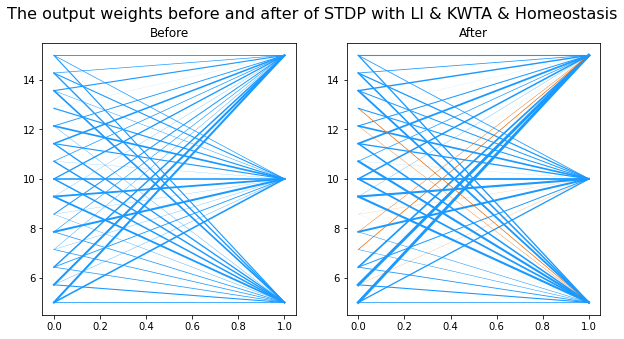

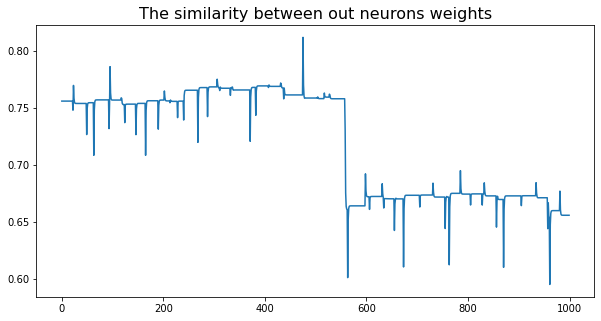

In [27]:
import matplotlib.pyplot as plt
print(f"Patterns:")
for i in range(len(dataset.pats)):
    print(f"\t{i}:{dataset.pats[i]}")


print(oldW)
print(oldW.sum(0))
print(newW)
print(newW.sum(0))
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
draw_weights(weights=oldW, ax=ax[0], scale_w=1)
draw_weights(weights=newW, ax=ax[1], scale_w=1)
title = "The output weights before and after of STDP"
if USE_KWTA:
    if USE_LI:
        title += " with LI & KWTA"
        if USE_AH or USE_VH:
            title += " & Homeostasis"
    else:
        title += " with KWTA"
elif USE_LI:
    title += " with LI"

plt.suptitle(title, fontsize=16)
ax[0].set_title("Before")
ax[1].set_title("After")
plt.show()

from torch.nn.functional import cosine_similarity
w_history = synapsis_input_out['weights'][0]
sim_history = []
for iter in range(w_history.shape[0]):
    sim_history.append(cosine_similarity(w_history[iter, :, 0], w_history[iter, :, 1], dim=0))
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(sim_history)
ax.set_title("The similarity between out neurons weights", fontsize=16)
plt.show()



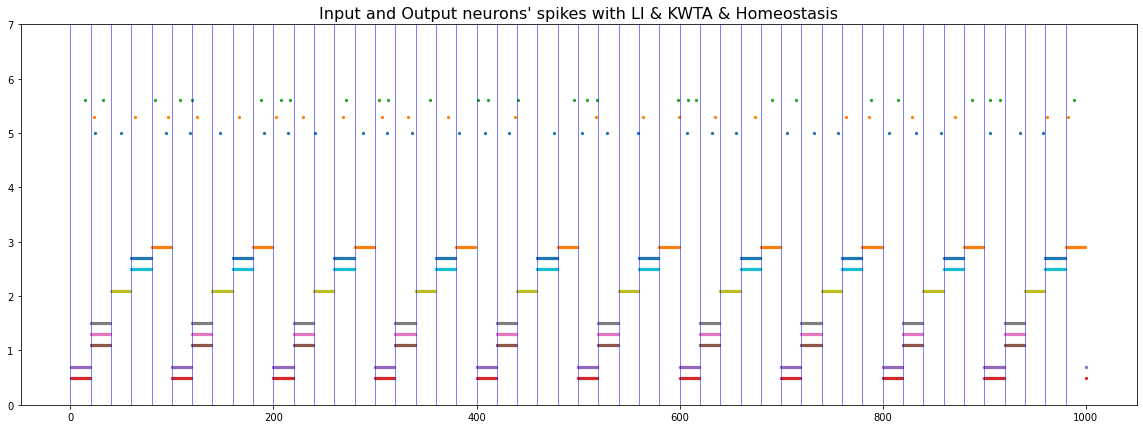

In [28]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(20, 7))

# plot output neurons
spikes = out_ng['spikes'][0]
for i in spikes[:, 1].unique():
    times = spikes[:, 1] == i
    ax.scatter(x=spikes[times][:, 0], y=5 + 0.3 * i * torch.ones(times.sum()), marker='.', s=20)

# plot input neurons
spikes = input_layer['spikes'][0]
for i in spikes[:, 1].unique():
    times = spikes[:, 1] == i
    ax.scatter(x=spikes[times][:, 0], y=0.5 + 0.2 * i * torch.ones(times.sum()), marker='.', s=20)

# add lines
for i in range(0, ITERS, 20):
    ax.axvline(i, color="blue", linewidth=0.5)
    
ax.set_ylim(0, 7)
title = "Input and Output neurons' spikes"
if USE_KWTA:
    if USE_LI:
        title += " with LI & KWTA"
        if USE_AH or USE_VH:
            title += " & Homeostasis"
    else:
        title += " with KWTA"
elif USE_LI:
    title += " with LI"

ax.set_title(title, fontsize=16)
plt.show()


